In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = 8, 8
from IPython.display import Image

In [560]:
import pymc3 as pm
import random
import numpy as np
from scipy.stats import beta, binom, multinomial
import pandas as pd
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def normalize(array):
    '''
    Given an array, this function normalizes the array by a sum
    '''    
    return array / array.sum()

def chunks(l, nun_samples):
    """returns successive n-sized chunks from l."""
    
    splits = []
    for i in range(0, len(l), nun_samples):
        splits.append(l[i:i + nun_samples])
        
    return splits

# Chapter 7: Markov Chain Monte Carlo

Markov Chain Monte Carlo is a method of sampling from probability distributions.

## Metropolis Algorithm

Imagine a group of islands in a row with various populations. The goal is to move through all the islands while focusing on the islands with large populations. This is analagous to sampling more values from a certain range because of its high probability. First the left or right island is randomly chosen. If the chosen island has a higher population, then you move to that island. On the other hand, if the population is lower, you move to the island probabilistically by the ratio of the new island population and the original island population. 

Below is an example of this. We start at 4 at time 1 and then move according to this procedure until time 500. The frequency of visits to each island is proportional to the initial visit probability.



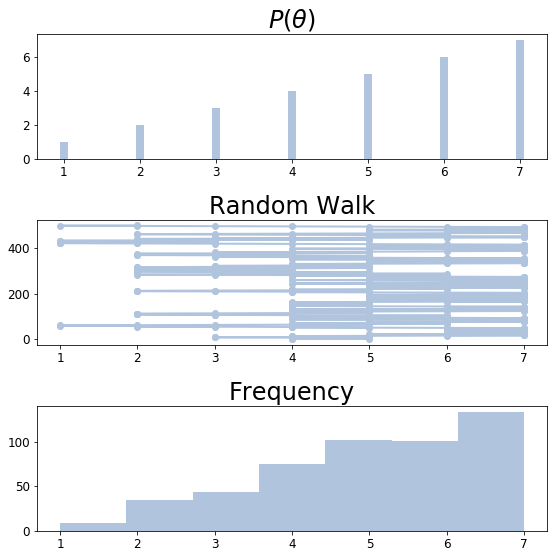

In [17]:
fig, axs = plt.subplots(3,1)

thetas = np.array(range(1,8))
axs[0].bar(thetas, thetas, label= 'P-theta', width = 0.1, color = 'lightsteelblue');

time = np.array(range(1,501))
visits = [4]
for t in time[1:]:
    if random.random() >= 0.5:
        new_island = visits[-1] + 1
        if new_island == 8: new_island = 7
        visits.append(new_island)
    else:
        new_island = visits[-1] - 1
        if new_island == 0: new_island = 1       
            
        if random.random() <= new_island / visits[-1]: visits.append(new_island)
        else: visits.append(visits[-1])
    
axs[1].plot(visits,time, marker='o', color = 'lightsteelblue')
axs[2].hist(visits, color = 'lightsteelblue', bins = 7)

axs[0].set_title(r'$P(\theta)$')
axs[1].set_title('Random Walk')
axs[2].set_title('Frequency')
fig.tight_layout()

The metropolis algorithm can be extended to continuous, multidimensional space. A coin is flipped N times with z heads. Below is an example of the metropolis algorithm applied to this event.

The likelihood function is defined as

$$ p(z,N \vert \theta) = \theta^z(1-\theta)^{N-z}$$

and the prior is defined as 

$$ p(\theta) = beta(\theta \vert a,b) $$

Because the distribution is continuous, we need to define a distribution for the jump in $\theta$ during each time step. This distribution is defined as

$$ \Delta \theta \sim Normal(0,\sigma) $$

where 0 is the mean and $\sigma$ is the standard deviation of the normal distribution.

The steps to the Metropolis Algorithm are as follows:

- Pick a starting value for $\theta$
- Generate a new value for $\theta$ defined by $\theta_{new} = \theta_{old} + \Delta \theta$
- Find the probability of moving
$$ p_{move} = \min\Big(\frac{P(\theta_{new})}{P(\theta_{old})},1\Big) $$

$$ = \min\Big(\frac{p(D\vert\theta_{new})p(\theta_{new})}{p(D\vert\theta_{old})p(\theta_{old})},1\Big) $$

$$ = \min\Big(\frac{Bernoulli(z,N \vert \theta_{new})beta(\theta_{new} \vert a,b)}{Bernoulli(z,N \vert \theta_{old})beta(\theta_{old} \vert a,b)},1\Big) $$

- If a randomly generated number is less than $p_{move}$, then update $\theta_{new} = \theta_{old} + p_{jump}$. If not, there is no change. Repeat this process until enough samples are produced.

Below are examples of the algorithm with a beta prior, N = 20, z = 14. The standard deviations are 0.02, 0.2, and 2.

In [570]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].

code taken from https://github.com/aloctavodia/Doing_bayesian_data_analysis
"""
# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def func_likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = sum(data[data == 1])  # number of 1's in Data
    N = len(data)  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def func_prior(theta):
    theta = np.array(theta) # ensure you have an array
    prior = beta.pdf(theta, 2, 2)

    return prior


# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = func_likelihood(theta , data) * func_prior(theta)
    return target_rel_prob

def metropolis(data, start,traj_length, burn_in, mu, std):
    # Specify the length of the trajectory, i.e., the number of jumps to try:
    traj_length = traj_length # arbitrary large number
    # Initialize the vector that will store the results:
    trajectory = np.zeros(traj_length)
    # Specify where to start the trajectory:
    trajectory[0] = start # arbitrary value
    # Specify the burn-in period:
    burn_in = 0
    
    n_accepted = 0
    n_rejected = 0

    # Now generate the random walk. The 't' index is time or trial in the walk.
    for t in range(traj_length-1):
        current_position = trajectory[t]
        # Use the proposal distribution to generate a proposed jump.
        # The shape and variance of the proposal distribution can be changed
        # to whatever you think is appropriate for the target distribution.
        proposed_jump = np.random.normal(loc=mu , scale=std, size=1)

    #    # Compute the probability of accepting the proposed jump.
        prob_accept = np.minimum(1, 
                                target_rel_prob(current_position + proposed_jump, data)
                                / target_rel_prob(current_position, data))
    #    # Generate a random uniform value from the interval [0,1] to
    #    # decide whether or not to accept the proposed jump.
        if np.random.rand() < prob_accept:
            # accept the proposed jump
            trajectory[t+1] = current_position + proposed_jump
            # increment the accepted counter, just to monitor performance
            if t > burn_in:
                n_accepted += 1
        else:
            # reject the proposed jump, stay at current position
            trajectory[t+1] = current_position
            # increment the rejected counter, just to monitor performance
            if t > burn_in:
                n_rejected += 1
                
    return trajectory

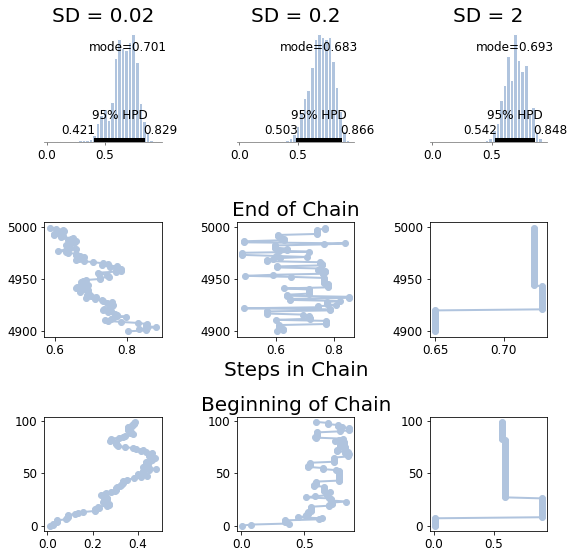

In [620]:
# 14 heads and 6 tails
data = np.repeat([1,0],[14,6])
# shape parameters for beta distribution
a = 1
b = 1

def func_prior(theta):
    theta = np.array(theta)
    prior = beta.pdf(theta, a = 1,b = 1)
    return prior


# number of samples
samples = 5000

deviation = [0.02, 0.2,2]

fig, axs = plt.subplots(3,3)

for grid in range(3):

    trajectory = metropolis(data = data, start = 0.01,traj_length = 5000, burn_in = 0, mu = 0, std = deviation[grid])
    
    axs[2,grid].plot(trajectory[:100],range(0,100) , label='first', marker = 'o', color = 'lightsteelblue');
    axs[1,grid].plot(trajectory[4900:],range(4900,5000) , label='end', marker = 'o', color = 'lightsteelblue');
    pm.plots.plot_posterior(trajectory, label='post', color = 'lightsteelblue',point_estimate = 'mode',ax = axs[0,grid])
    axs[0,grid].set_title('SD = ' + str(deviation[grid]))
#     axs[1,grid].bar(thetas,binom.pmf(k = 0.25 * Ns[grid],n = Ns[grid], p = thetas), width = 0.01, color = 'lightsteelblue')
#     annot = 'Data: z = ' + str(int(Ns[grid]*0.25)) + '\nN = ' + str(Ns[grid])
#     axs[1,grid].annotate(annot, xy=(0.5,0.8), xycoords="axes fraction")      
#     pm.plots.plot_posterior(traces[grid], label='post', color = 'lightsteelblue', ax = axs[2,grid])
    

axs[1,1].set_title('End of Chain')
axs[1,1].set_xlabel('Steps in Chain')
axs[2,1].set_title('Beginning of Chain')
fig.tight_layout()

The Metropolis Algorithm can be extended to further dimensions. For example, a experiment is done with 2 coins, its bias denoted by $\theta_j$ and the number of heads by $z_j$. The results of the coins are independent. The prior belief of the coins can be written as $p(\theta_1, \theta_2)$ where

$$ \int \int p(\theta_1, \theta_2) d\theta_1 d\theta_2 = 1$$

Because the coin flips are independent, $p(\theta_1, \theta_2) = p(\theta_1)p(\theta_2)$. Also, given a flip of one of the coins, $ p(y_1 \vert \theta_1, \theta_2) = p(y_1 \vert \theta_1)$ and $ p(y_2 \vert \theta_1, \theta_2) = p(y_2 \vert \theta_2)$.

We denote D as the set $\{z_1,N_1,z_2,N_2\}$. The likelihood function is thus

$$ p(D \vert \theta_1, \theta_2) = \prod_{y_{1i} \in D_1} p(y_{1i} \vert \theta_1, \theta_2) \prod_{y_{2i} \in D_2} p(y_{2i} \vert \theta_1, \theta_2)$$

$$ = \theta_1^{z_1}(1-\theta_1)^{N_1 - z_1}\theta_2^{z_2}(1-\theta_2)^{N_2 - z_2} $$

The posterior distribution is

$$ (\theta_1, \theta_2 \vert D) = p(D \vert \theta_1, \theta_2)p(\theta_1,\theta_2) / p(D) $$

$$ = \frac{\theta_1^{z_1}(1-\theta_1)^{N_1 - z_1}\theta_2^{z_2}(1-\theta_2)^{N_2 - z_2}p(\theta_1,\theta_2)}{\int \int p(\theta_1, \theta_2) d\theta_1 d\theta_2}$$

If the prior is a beta function with parameters a and b, the posterior distribution reduces to 

$$ \frac{\theta_1^{z_1+a_1-1}(1-\theta_1)^{N_1-z_1+b_1-1}\theta_2^{z_2+a_2-1}(1-\theta_2)^{N_2-z_2+b_2-1}}{p(D)B(a_1,b_1)B(a_2,b_2)} $$

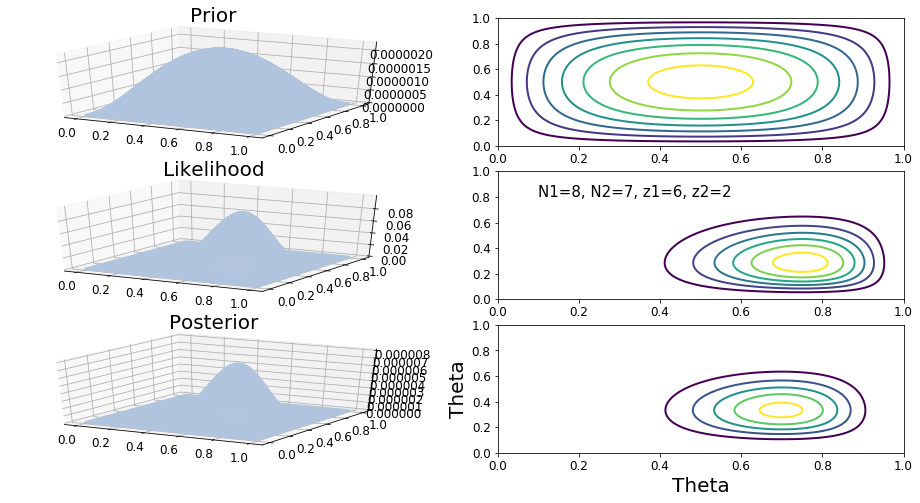

In [424]:
thetas = np.linspace(0,1,1001)
a = b = 2
N1 = 8
N2 = 7
z1 = 6
z2 = 2

fig = plt.figure(figsize=plt.figaspect(0.5))

# plot the 3d prior
ax = fig.add_subplot(321, projection='3d')
x = y = thetas
X, Y = np.meshgrid(x, y)
prior = normalize(beta.pdf(X,a,b)*beta.pdf(Y,a,b))
ax.plot_wireframe(X, Y, prior, rstride=10, cstride=10, color = 'lightsteelblue')
ax.set_title('Prior')
# plot the 2d prior contour
ax = fig.add_subplot(322)
ax.contour(X, Y, prior)

# plot the 3d likelihood
ax = fig.add_subplot(323, projection='3d')
x = y = thetas
X, Y = np.meshgrid(x, y)
likelihood = binom.pmf(k = z1,n = N1, p = X)*binom.pmf(k = z2,n = N2, p = Y)
ax.plot_wireframe(X, Y, likelihood, rstride=10, cstride=10, color = 'lightsteelblue')
ax.set_title('Likelihood')
# plot the 2d likelihood contour
ax = fig.add_subplot(324)
ax.contour(X, Y, likelihood)
annot = 'N1=8, N2=7, z1=6, z2=2'    
ax.annotate(annot, xy=(0.1,0.8), xycoords="axes fraction")

# plot the 3d posterior
ax = fig.add_subplot(325, projection='3d')
x = y = thetas
X, Y = np.meshgrid(x, y)
prob_data = np.multiply(prior,likelihood).sum()
posterior = np.multiply(prior,likelihood) / prob_data
ax.plot_wireframe(X, Y, posterior, rstride=10, cstride=10, color = 'lightsteelblue')
ax.set_title('Posterior')
# plot the 2d posterior contour
ax = fig.add_subplot(326)
ax.contour(X, Y, posterior)
ax.set_xlabel('Theta')
ax.set_ylabel('Theta')

plt.show()
fig.tight_layout()

## Gibbs Sampling

Gibbs sampling is a variation on the Metropolis Algorithm that has a more efficient sampling procedure. Starting at some random point in the parameter space, each jump is made by first choosing a parameter. This can either be done randomly or by cycling through them. Assuming the chosen parameter is $\theta_i$, a new value is chosen for that parameter from the conditional probability distribution $p(\theta_i \vert \theta_{j \setminus i},D)$. The new point is now the original point with the new value for $\theta_i$. The graph below is an example of the conditional distributions. In the first run, a value for Theta1 is chosen from the black distribution. For the second run, a value for Theta2 is chosen from the red distribution.

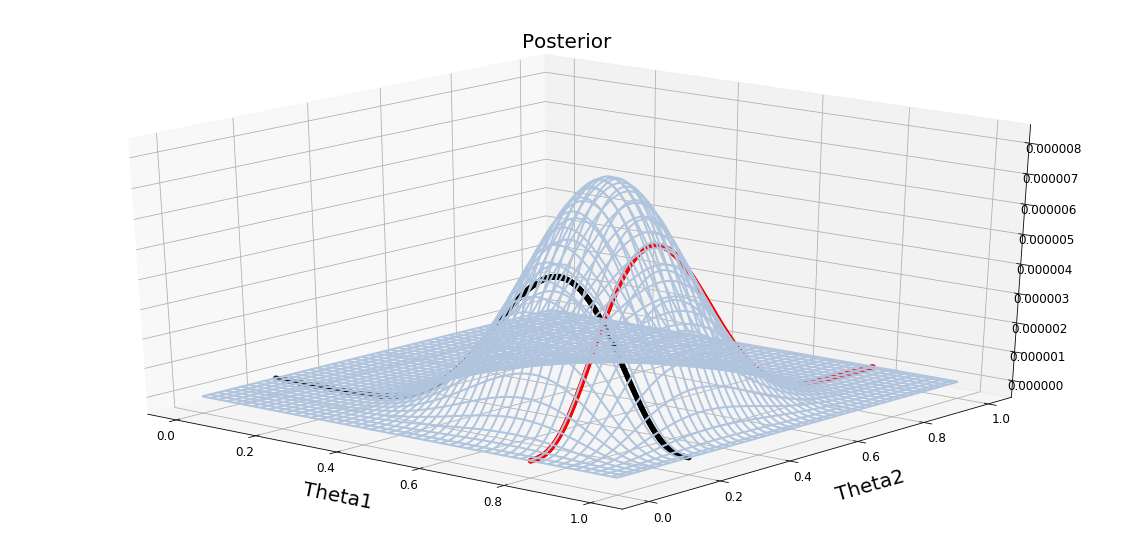

In [337]:
# plot the 3d posterior
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(111, projection='3d')
x = y = thetas
X, Y = np.meshgrid(x, y)
prob_data = np.multiply(prior,likelihood).sum()
posterior = np.multiply(prior,likelihood) / prob_data
ax.plot_wireframe(X, Y, posterior, color = 'lightsteelblue');
ax.set_title('Posterior')
ax.set_xlabel('Theta1', labelpad=20);
ax.set_ylabel('Theta2', labelpad=20);
ax.scatter(thetas,[0.2] * len(thetas),posterior[200] , color = 'black'); 
ax.scatter([0.8] * len(thetas),thetas,posterior[:,800] , color = 'red'); 
ax.view_init(azim=310, elev= 25)
fig.tight_layout()

There are some issues with the Gibbs sampler. First of all, it is only possible to use if the conditional probabilities of all the variables are possible to calculate and if random samples are able to be generated. Secondly, because only one parameter is considered at a time, highly correlated parameters will require large samples to truly represent of the conditional probability distribution.

## MCMC Representativeness, Accuracy and Efficiency

Goals:
1. The values from the chain must be representative of the posterior distribution and should be independent of the starting condition, given enough samples.
2. The chain must be large enough so that the estimates are accurate and stable. Any decisions made from a sample should be similar to all samples.
3. The chain should be generated efficiently.

## MCMC Representativeness

There are many ways to check representativeness. We show three of them below. 
1. Trace plots show many chains superimposed on one graph. If the chains represent the posterior distribution, they will overlap. The initial values of the chains will be different due to starting conditions. This range is typically referred to as the *burn in* and are typically removed. 
2. Density plots of superimposed chains will also have a large overlap if sampled correctly. The HDI should also be similar.
3. The Gelman Rubin statistic checks for convergence among the chains by comparing the between chain variance and the within chain variance. A value close to 1 means the chains are almost fully converged

## MCMC Accuracy

In order to make sure that successive samples are independent, the autocorrelation is plotted for multiple lags. Ideally, the autocorrelation will decrease as the lag increases. 

## MCMC Efficiency

1. Run chains using parallel computations.
2. Choose efficient sampling methods - depends on problems
3. Try to reduce number of parameters.

In [478]:
# number of trials in experiment
N = 4
# number of heads
z = 1
# shape parameters for beta distribution
a = 2
b = 2

# get samples of posterior from beta prior
with pm.Model() as model: # context management
    # number of samples
    samples = 5000
    # define priors
    p = pm.Beta('p', a,b)

    # define likelihood
    y = pm.Binomial('y', n=N, p=p, observed=z)

    trace = pm.sample(samples, progressbar=False, chains = 3);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [p_logodds__]


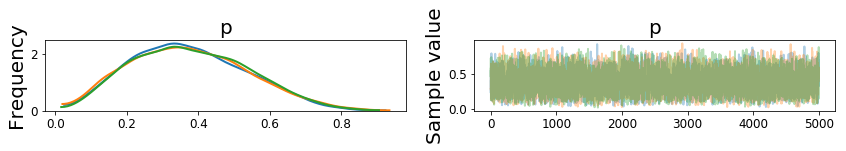

In [479]:
pm.plots.traceplot(trace);

In [480]:
print('Gelman Rubin Statistic = ', pm.gelman_rubin(trace)['p'])

Gelman Rubin Statistic =  1.00023279298


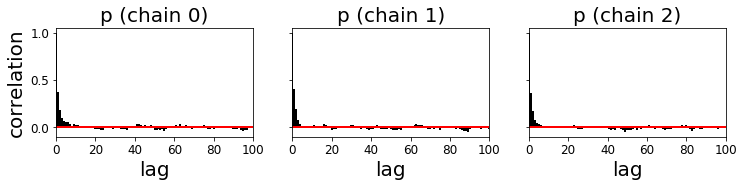

In [481]:
pm.plots.autocorrplot(trace,varnames = 'p');

# Chapter 7: Exercises

## Exercise 7.1
proposalSD = c(0.02,0.2,2.0)

Include the graphs in your write-up and describe whether they show similar behavior as the corresponding trajectories in Figure 7.4. Be sure to discuss the ESS.

Answer: All values of the standard deviation shows similar results.

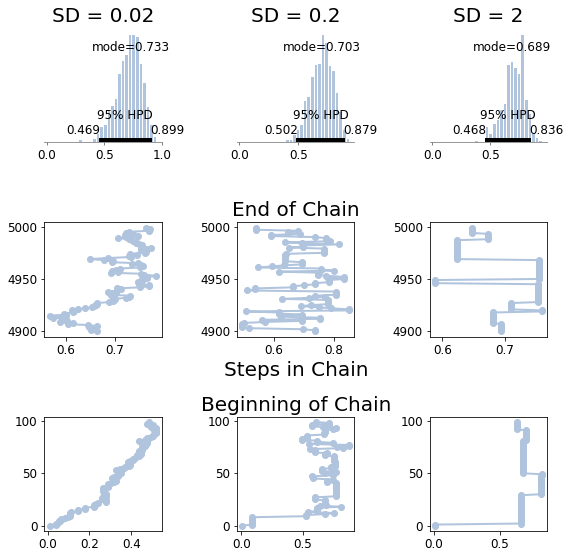

In [621]:
# 14 heads and 6 tails
data = np.repeat([1,0],[14,6])
# shape parameters for beta distribution
a = 1
b = 1
# number of samples
samples = 5000

def func_prior(theta):
    theta = np.array(theta) # ensure you have an array
    prior = beta.pdf(theta, a = 1, b = 1)
    return prior

deviation = [0.02, 0.2,2]

fig, axs = plt.subplots(3,3)

for grid in range(3):

    trajectory = metropolis(data = data, start = 0.01,traj_length = 5000, burn_in = 0, mu = 0, std = deviation[grid])
    
    axs[2,grid].plot(trajectory[:100],range(0,100) , label='first', marker = 'o', color = 'lightsteelblue');
    axs[1,grid].plot(trajectory[4900:],range(4900,5000) , label='end', marker = 'o', color = 'lightsteelblue');
    pm.plots.plot_posterior(trajectory, label='post', color = 'lightsteelblue',point_estimate = 'mode',ax = axs[0,grid])
    axs[0,grid].set_title('SD = ' + str(deviation[grid]))

axs[1,1].set_title('End of Chain')
axs[1,1].set_xlabel('Steps in Chain')
axs[2,1].set_title('Beginning of Chain')
fig.tight_layout()

## Exercise 7.2

B. Repeat the previous exercise, with the lines above appended to the script. Include the resulting new graphs in your write-up. For each run, verify that the height of the ACF bar at the specified lag matches the correlation in the scatterplot.

Answer: For each standard deviation, the autocorrelation at lag 10, matches the manual calculation of the correlation of the trajectory.

C. When the proposal distribution has SD=2, why does the scatter plot have a dense line of points on the diagonal?

Answer: There is a diagonal because for many of the steps, the value at 10 steps ahead is the same.

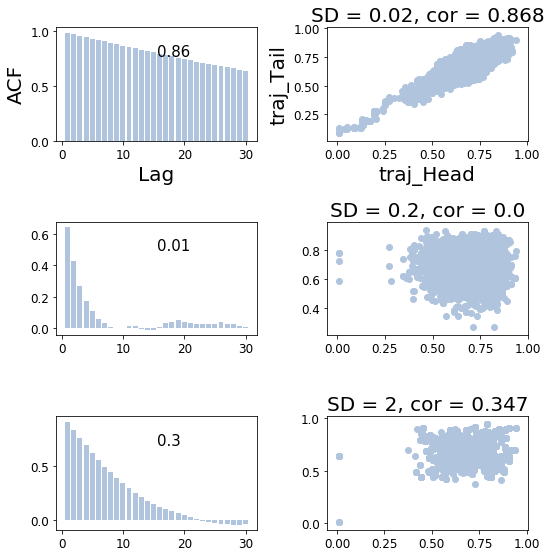

In [622]:
# 14 heads and 6 tails
data = np.repeat([1,0],[14,6])
# shape parameters for beta distribution
a = 1
b = 1
# number of samples
samples = 5000

lag = 10

def func_prior(theta):
    theta = np.array(theta) # ensure you have an array
    prior = beta.pdf(theta, 1, 1)
    return prior

deviation = [0.02, 0.2,2]

fig, axs = plt.subplots(3,2)

for grid in range(3):

    trajectory = metropolis(data = data, start = 0.01,traj_length = 5000, burn_in = 0, mu = 0, std = deviation[grid])
    df = pd.Series(trajectory)
    lags = range(1,31)
    autocor = [df.autocorr(lag=x) for x in lags]  
    axs[grid,0].bar(lags,autocor,color = 'lightsteelblue') 
    axs[grid,0].annotate(str(round(autocor[10],2)), xy=(0.5,0.75), xycoords="axes fraction")      

    
    traj_head= trajectory[:samples-lag]
    traj_tail = trajectory[lag:]
    cor = np.round(np.corrcoef(traj_head, traj_tail)[0, 1],3)
    text = 'SD = ' + str(deviation[grid]) + ', cor = ' + str(cor)
    axs[grid,1].set_title(text)
    axs[grid,1].scatter(traj_head,traj_tail,color = 'lightsteelblue')
    

axs[0,0].set_xlabel('Lag')
axs[0,0].set_ylabel('ACF')
axs[0,1].set_xlabel('traj_Head')
axs[0,1].set_ylabel('traj_Tail')
fig.tight_layout()

## 7.3

Consider a prior distribution on the bias of a coin that puts most the credibility at 0, 0,5, and 1, formualted as $p(\theta) = \frac{(\cos(4\pi \theta) + 1)^2}{1.5}$.

B. Make a plot of the prior.

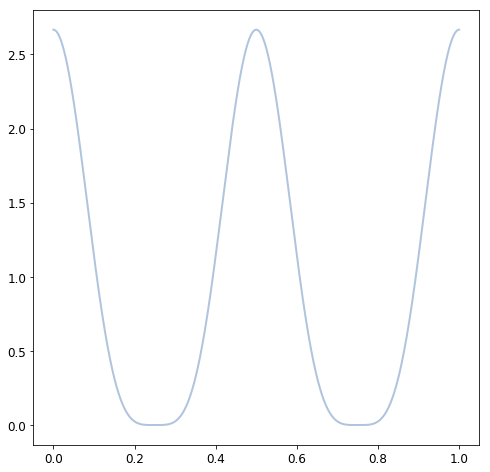

In [564]:
fig, ax = plt.subplots()

thetas = np.linspace(0,1,1000)
p_theta_func = lambda x: (math.cos(4 * math.pi * x) + 1)**2 / 1.5
p_theta = [p_theta_func(theta) for theta in thetas]

ax.plot(thetas, p_theta,color='lightsteelblue');

C. Using a proposal SD=0.2 and the new prior distribution, graph the histogram of the trajectory using the metropolis algorithm with no coin flips. Also graph the start and the end of the chain. Does the posterior represent the prior well?

Answer: Yes, the posterior is also a trimodal distribution, similar to the prior. 

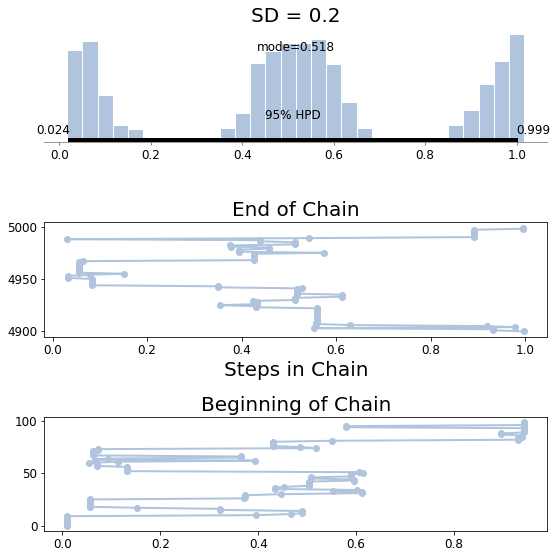

In [627]:
# 1 heads and 0 tails
data = np.repeat([1,0],[0,0])

# prior distribution
def func_prior(theta):
    prior = (math.cos(4 * math.pi * theta) + 1)**2 / 1.5
    if theta > 1 or theta < 0: prior = 0
    return prior

# number of samples
samples = 5000
std = 0.2
fig, axs = plt.subplots(3,1)

trajectory = metropolis(data = data, start = 0.01,traj_length = samples, burn_in = 0, mu = 0, std = std)

axs[2].plot(trajectory[:100],range(0,100) , label='first', marker = 'o', color = 'lightsteelblue');
axs[1].plot(trajectory[4900:],range(4900,5000) , label='end', marker = 'o', color = 'lightsteelblue');
pm.plots.plot_posterior(trajectory, label='post', color = 'lightsteelblue',point_estimate = 'mode',ax = axs[0])
axs[0].set_title('SD = ' + str(std))

axs[1].set_title('End of Chain')
axs[1].set_xlabel('Steps in Chain')
axs[2].set_title('Beginning of Chain')
fig.tight_layout()

D. Repeat the previous process but this time with 3 coin flips: 2 heads and 1 tail.

Answer: The posterior distribution makes sense because the probability of the coin bias being less than 0.5 is low.

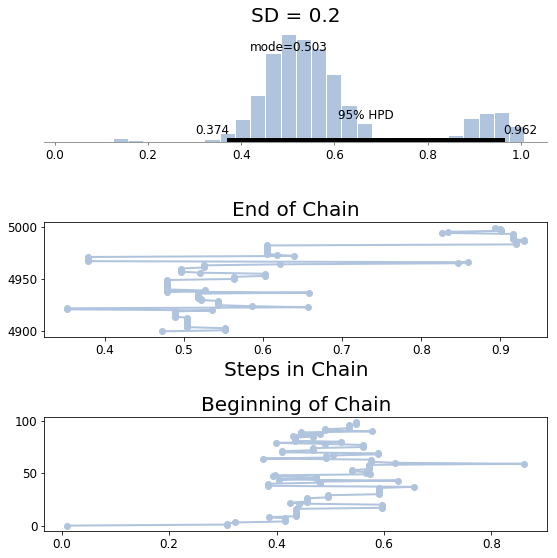

In [630]:
# 2 heads and 1 tails
data = np.repeat([1,0],[2,1])

# prior distribution
def func_prior(theta):
    prior = (math.cos(4 * math.pi * theta) + 1)**2 / 1.5
    if theta > 1 or theta < 0: prior = 0
    return prior

# number of samples
samples = 5000
std = 0.2
fig, axs = plt.subplots(3,1)

trajectory = metropolis(data = data, start = 0.01,traj_length = samples, burn_in = 0, mu = 0, std = std)

axs[2].plot(trajectory[:100],range(0,100) , label='first', marker = 'o', color = 'lightsteelblue');
axs[1].plot(trajectory[4900:],range(4900,5000) , label='end', marker = 'o', color = 'lightsteelblue');
pm.plots.plot_posterior(trajectory, label='post', color = 'lightsteelblue',point_estimate = 'mode',ax = axs[0])
axs[0].set_title('SD = ' + str(std))

axs[1].set_title('End of Chain')
axs[1].set_xlabel('Steps in Chain')
axs[2].set_title('Beginning of Chain')
fig.tight_layout()

D. Repeat the previous part but now with proposal SD=0.02. Include the graphical output in your write-up. Does the posterior distribution make sense? Explain why not; what has gone wrong? If we did not know from the previous part that this output was unrepresentative of the true posterior, how could we try to check?

Answer: The posterior distribution makes sense because since the standard deviation is so low, the trajectory never escaped the initial starting point of 0.01. Since you cannot tell the effects the of the starting condition, this analysis must be run with different starting conditions to check for convergence.

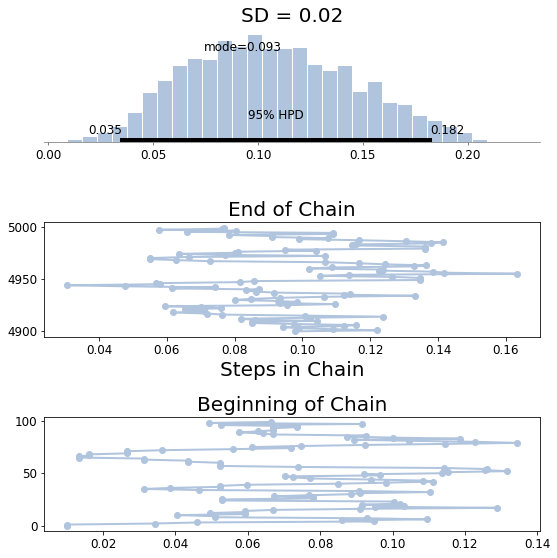

In [632]:
# 2 heads and 1 tails
data = np.repeat([1,0],[2,1])

# prior distribution
def func_prior(theta):
    prior = (math.cos(4 * math.pi * theta) + 1)**2 / 1.5
    if theta > 1 or theta < 0: prior = 0
    return prior

# number of samples
samples = 5000
std = 0.02
fig, axs = plt.subplots(3,1)

trajectory = metropolis(data = data, start = 0.01,traj_length = samples, burn_in = 0, mu = 0, std = std)

axs[2].plot(trajectory[:100],range(0,100) , label='first', marker = 'o', color = 'lightsteelblue');
axs[1].plot(trajectory[4900:],range(4900,5000) , label='end', marker = 'o', color = 'lightsteelblue');
pm.plots.plot_posterior(trajectory, label='post', color = 'lightsteelblue',point_estimate = 'mode',ax = axs[0])
axs[0].set_title('SD = ' + str(std))

axs[1].set_title('End of Chain')
axs[1].set_xlabel('Steps in Chain')
axs[2].set_title('Beginning of Chain')
fig.tight_layout()

E. Repeat the previous part but now with the initial position at 0.99. In conjunction with the previous part, what does this result tell us?

Answer: This result tells us that distribution is extremely sensitive to the starting conditions when choosing such a small standard deviation.

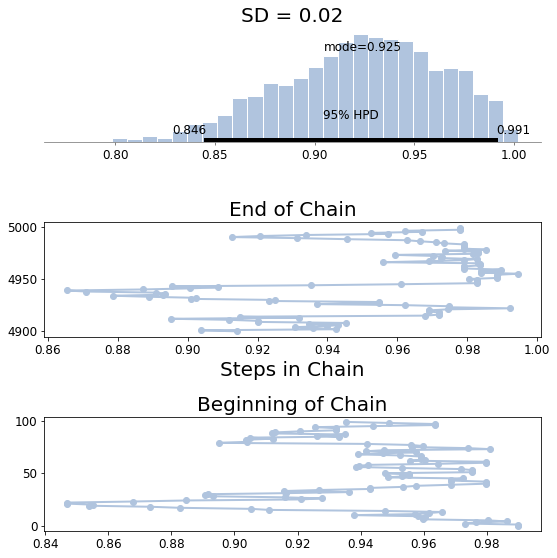

In [633]:
# 2 heads and 1 tails
data = np.repeat([1,0],[2,1])

# prior distribution
def func_prior(theta):
    prior = (math.cos(4 * math.pi * theta) + 1)**2 / 1.5
    if theta > 1 or theta < 0: prior = 0
    return prior

# number of samples
samples = 5000
std = 0.02
fig, axs = plt.subplots(3,1)

trajectory = metropolis(data = data, start = 0.99,traj_length = samples, burn_in = 0, mu = 0, std = std)

axs[2].plot(trajectory[:100],range(0,100) , label='first', marker = 'o', color = 'lightsteelblue');
axs[1].plot(trajectory[4900:],range(4900,5000) , label='end', marker = 'o', color = 'lightsteelblue');
pm.plots.plot_posterior(trajectory, label='post', color = 'lightsteelblue',point_estimate = 'mode',ax = axs[0])
axs[0].set_title('SD = ' + str(std))

axs[1].set_title('End of Chain')
axs[1].set_xlabel('Steps in Chain')
axs[2].set_title('Beginning of Chain')
fig.tight_layout()